<a href="https://colab.research.google.com/github/janecww/nlp-analytics/blob/main/Codes/Task%203/Steps_1%2C_3%2C_4%2C_5_Stock_Cluster_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import requests
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys
from selenium import webdriver

import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
#https://en.wikipedia.org/wiki/List_of_Hong_Kong_exchange-traded_funds


from pylab import plot,show
from numpy import vstack,array
from numpy.random import rand
import pandas_datareader as dr
from math import sqrt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import SilhouetteVisualizer
import plotly.express as px

# Task 1: Collect Stock Tickers

In [ ]:
def process(symbol):
    if len(symbol) == 1:
        symbol = '000'+symbol+'.HK'
    elif len(symbol) == 2:
        symbol = '00'+symbol+'.HK'
    elif len(symbol) == 3:
        symbol = '0'+symbol+'.HK'
    else:
        symbol = symbol+'.HK'
    return symbol


In [ ]:
# Collect stock Tickers (S&P1200)
#driver = Chrome("C:/Users/Jane Wong/OneDrive - HKUST Connect/chromedriver.exe")

#S&P 500 Index
sp500_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
sp500_data = pd.read_html(sp500_page)
sp500_ticker = [sp500_data[0]['Symbol'][i] for i in range(len(sp500_data[0]['Symbol']))]
sp500_name = [sp500_data[0]['Security'][i] for i in range(len(sp500_data[0]['Security']))]
sp500_sector = [sp500_data[0]['GICS Sector'][i] for i in range(len(sp500_data[0]['GICS Sector']))]
sp500_subSector =  [sp500_data[0]['GICS Sub-Industry'][i] for i in range(len(sp500_data[0]['GICS Sub-Industry']))]
sp500_country = ['USA' for i in range(len(sp500_data[0]['GICS Sub-Industry']))]

#Hang Seng Index (HK)
hase_page = requests.get('https://en.wikipedia.org/wiki/Hang_Seng_Index').text
hase_data = pd.read_html(hase_page)
hase_ticker = [ process(hase_data[6]['Ticker'][i][6:]) for i in range(len(hase_data[6]['Ticker']))]
hase_name = [ hase_data[6]['Name'][i] for i in range(len(hase_data[6]['Name']))]
hase_sector = [hase_data[6]['Sub-index'][i] for i in range(len(hase_data[6]['Sub-index']))]
hase_country = ['Hong Kong' for i in range(len(hase_data[6]['Ticker']))]


#Combine
stock_ticker = sp500_ticker + hase_ticker
stock_name = sp500_name + hase_name
stock_sector = sp500_sector + hase_sector
stock_country = sp500_country + hase_country
stock_df = pd.DataFrame({'Ticker': stock_ticker, 'Company': stock_name, 'Sector': stock_sector, 'Country':stock_country})
stock_df

,Ticker,Company,Sector,Country
0,MMM,3M,Industrials,USA
1,AOS,A. O. Smith,Industrials,USA
2,ABT,Abbott,Health Care,USA
3,ABBV,AbbVie,Health Care,USA
4,ACN,Accenture,Information Technology,USA
...,...,...,...,...
571,9618.HK,JD.com,Commerce & Industry,Hong Kong
572,9633.HK,Nongfu Spring,Commerce & Industry,Hong Kong
573,9888.HK,Baidu,Commerce & Industry,Hong Kong
574,9988.HK,Alibaba Group,Commerce & Industry,Hong Kong


In [ ]:
stock_df['Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy', 'Finance', 'Properties',
       'Commerce & Industry'], dtype=object)

In [ ]:
stock_df['Sector'] = stock_df['Sector'].replace('Finance', 'Financials')
stock_df['Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Communication Services', 'Consumer Staples',
       'Consumer Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real Estate', 'Energy', 'Properties', 'Commerce & Industry'],
      dtype=object)

In [ ]:
stock_df.to_csv('stock_df.csv')

In [ ]:
tickers = stock_df['Ticker'].to_list()
tickers

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADM',
 'ADBE',
 'ADP',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALK',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AMD',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'AON',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ACGL',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BKR',
 'BALL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'WRB',
 'BRK.B',
 'BBY',
 'BIO',
 'TECH',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF.B',
 'CHRW',
 'CDNS',
 'CZR',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CARR',
 'CTLT',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CDAY',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA

# Task 2: Collect Info for Each Ticker
- See: https://colab.research.google.com/drive/1MmN6OvqOSFPx2IJvcHcP7BdBFrmXnP65?usp=sharing (or another ipynb file: Stock Info Extraction)


In [ ]:
#upload the resulting dataset
df_all = pd.read_csv('stock_fina_esg_data.csv')
df_all

,Unnamed: 0,Symbol,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
0,0,1,1.000000,1.00000,1.000000,1.000,1.00,1.00,1.00,1.00,1.00,1
1,MMM,MMM,0.986396,0.18914,11.057591,11.635,11.46,33.61,12.33,13.56,7.72,3
2,AOS,AOS,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0
3,ABT,ABT,0.667596,0.17519,25.356660,14.616,4.43,24.98,3.03,13.59,8.36,3
4,ABBV,ABBV,0.623997,0.23188,22.206667,11.653,7.50,27.84,1.12,16.77,9.95,3
...,...,...,...,...,...,...,...,...,...,...,...,...
490,2319.HK,2319.HK,0.654901,0.06481,22.365269,27.425,1.67,34.00,14.56,12.71,6.72,0
491,9618.HK,9618.HK,0.431112,0.00213,378.787870,15.457,0.66,27.75,8.56,10.53,8.66,2
492,9888.HK,9888.HK,0.627485,0.03494,NaN,-1.005,NaN,20.72,2.99,9.29,8.44,3
493,9988.HK,9988.HK,0.537495,0.01620,135.466660,0.667,0.75,26.40,2.97,11.59,11.84,4


In [ ]:
#Drop irrelevant column(s)
df_all = df_all.drop(columns = ['Unnamed: 0'])
df_all

,Symbol,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
0,1,1.000000,1.00000,1.000000,1.000,1.00,1.00,1.00,1.00,1.00,1
1,MMM,0.986396,0.18914,11.057591,11.635,11.46,33.61,12.33,13.56,7.72,3
2,AOS,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0
3,ABT,0.667596,0.17519,25.356660,14.616,4.43,24.98,3.03,13.59,8.36,3
4,ABBV,0.623997,0.23188,22.206667,11.653,7.50,27.84,1.12,16.77,9.95,3
...,...,...,...,...,...,...,...,...,...,...,...
490,2319.HK,0.654901,0.06481,22.365269,27.425,1.67,34.00,14.56,12.71,6.72,0
491,9618.HK,0.431112,0.00213,378.787870,15.457,0.66,27.75,8.56,10.53,8.66,2
492,9888.HK,0.627485,0.03494,NaN,-1.005,NaN,20.72,2.99,9.29,8.44,3
493,9988.HK,0.537495,0.01620,135.466660,0.667,0.75,26.40,2.97,11.59,11.84,4


In [ ]:
#Drop the first row
df_all.drop(index=df_all.index[0], axis=0, inplace=True)
df_all

,Symbol,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
1,MMM,0.986396,0.18914,11.057591,11.635,11.46,33.61,12.33,13.56,7.72,3
2,AOS,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0
3,ABT,0.667596,0.17519,25.356660,14.616,4.43,24.98,3.03,13.59,8.36,3
4,ABBV,0.623997,0.23188,22.206667,11.653,7.50,27.84,1.12,16.77,9.95,3
5,ACN,1.211925,0.11304,24.144394,15.857,11.15,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...,...
490,2319.HK,0.654901,0.06481,22.365269,27.425,1.67,34.00,14.56,12.71,6.72,0
491,9618.HK,0.431112,0.00213,378.787870,15.457,0.66,27.75,8.56,10.53,8.66,2
492,9888.HK,0.627485,0.03494,NaN,-1.005,NaN,20.72,2.99,9.29,8.44,3
493,9988.HK,0.537495,0.01620,135.466660,0.667,0.75,26.40,2.97,11.59,11.84,4


In [ ]:
#rename symbol to ticker
df_all.rename(columns = {'Symbol':'Ticker'}, inplace=True)
df_all

,Ticker,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
1,MMM,0.986396,0.18914,11.057591,11.635,11.46,33.61,12.33,13.56,7.72,3
2,AOS,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0
3,ABT,0.667596,0.17519,25.356660,14.616,4.43,24.98,3.03,13.59,8.36,3
4,ABBV,0.623997,0.23188,22.206667,11.653,7.50,27.84,1.12,16.77,9.95,3
5,ACN,1.211925,0.11304,24.144394,15.857,11.15,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...,...
490,2319.HK,0.654901,0.06481,22.365269,27.425,1.67,34.00,14.56,12.71,6.72,0
491,9618.HK,0.431112,0.00213,378.787870,15.457,0.66,27.75,8.56,10.53,8.66,2
492,9888.HK,0.627485,0.03494,NaN,-1.005,NaN,20.72,2.99,9.29,8.44,3
493,9988.HK,0.537495,0.01620,135.466660,0.667,0.75,26.40,2.97,11.59,11.84,4


In [ ]:
#Check missing data
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 1 to 494
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ticker              494 non-null    object 
 1   beta                494 non-null    float64
 2   profit_margin       494 non-null    float64
 3   pe_ratio            482 non-null    float64
 4   ev/ebita            459 non-null    float64
 5   eps                 493 non-null    float64
 6   total_esg           494 non-null    float64
 7   e_esg               492 non-null    float64
 8   s_esg               492 non-null    float64
 9   g_esg               492 non-null    float64
 10  highestControversy  494 non-null    int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 42.6+ KB


In [ ]:
#fill in missing data with mean value
pe_mean = df_all['pe_ratio'].mean()
ebita_mean = df_all['ev/ebita'].mean()
eps_mean = df_all['eps'].mean()
e_esg_mean = df_all['e_esg'].mean()
s_esg_mean = df_all['s_esg'].mean()
g_esg_mean = df_all['g_esg'].mean()

#gfg['G2'].fillna(value=mean_value, inplace=True)
df_all['pe_ratio'].fillna(value= pe_mean, inplace=True)
df_all['ev/ebita'].fillna(value = ebita_mean, inplace = True)
df_all['eps'].fillna(value = eps_mean, inplace = True)
df_all['e_esg'].fillna(value = e_esg_mean, inplace = True)
df_all['s_esg'].fillna(value = s_esg_mean, inplace = True)
df_all['g_esg'].fillna(value = g_esg_mean, inplace = True)
df_all

,Ticker,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
1,MMM,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3
2,AOS,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0
3,ABT,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3
4,ABBV,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3
5,ACN,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...,...
490,2319.HK,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0
491,9618.HK,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2
492,9888.HK,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3
493,9988.HK,0.537495,0.01620,135.466660,0.667,0.750000,26.40,2.97,11.59,11.84,4


# Task 3: Exploratory Data Analysis

In [ ]:
df_all.describe(include = 'all')

,Ticker,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
count,494,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000,494.000000
unique,494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,MMM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.012662,0.160192,32.250166,14.737660,7.837194,22.079534,5.773496,9.234878,7.037398,1.840081
std,NaN,0.418586,0.264180,65.306044,74.051184,21.620337,7.692987,5.428479,3.865984,2.413517,1.005428
min,NaN,0.183467,-2.151610,2.438642,-1389.019000,-20.787000,6.990000,0.000000,1.110000,3.080000,0.000000
25%,NaN,0.712329,0.068887,13.062914,9.871000,2.562500,16.040000,1.610000,6.570000,5.322500,1.000000
50%,NaN,0.988164,0.135860,21.379637,14.613000,4.885000,21.495000,3.700000,8.905000,6.485000,2.000000
75%,NaN,1.246425,0.228730,32.245984,18.820750,8.295000,26.815000,8.890000,11.612500,8.172500,2.000000


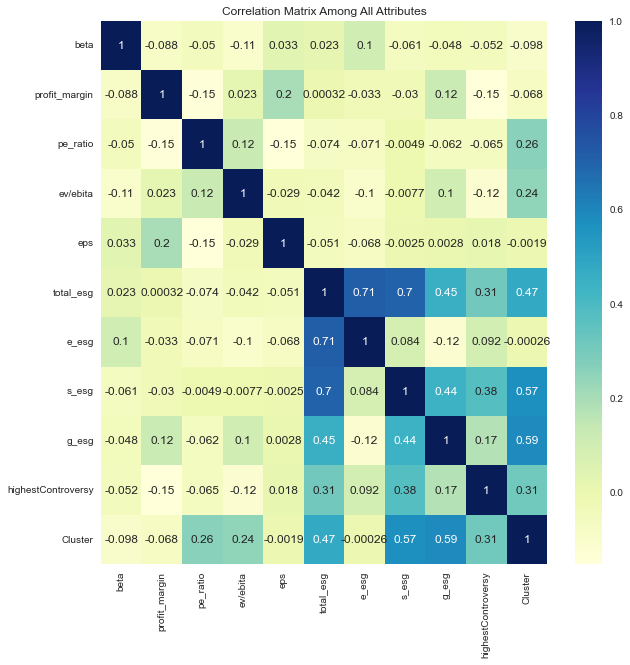

In [ ]:
#Correlation Matrix
corr = df_all.iloc[:,:].corr()
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix Among All Attributes')
g=sns.heatmap(df_all.corr(),annot=True,cmap="YlGnBu")

# Task 3: Detect Outliers & Standardize Data

In [ ]:
df_all.set_index('Ticker', inplace=True)
df_all

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
Ticker,,,,,,,,,,
MMM,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3
AOS,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0
ABT,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3
ABBV,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3
ACN,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...
2319.HK,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0
9618.HK,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2
9888.HK,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3


<AxesSubplot:xlabel='total_esg', ylabel='ev/ebita'>

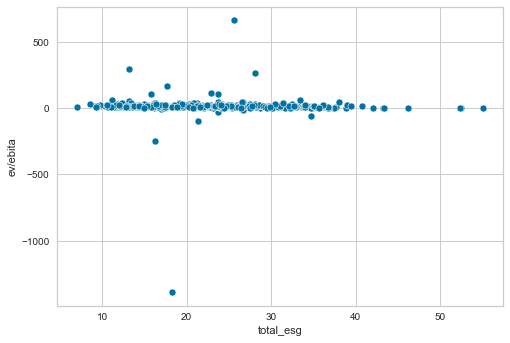

In [ ]:
#Detect outliers based on the relationship between ev/ebita and total_esg which has the lowest correlation
sns.scatterplot(data=df_all, x="total_esg", y="ev/ebita")

In [ ]:
#Identify the outlier
print(df_all['ev/ebita'].idxmin())

1928.HK


In [ ]:
#Drop the outlier
df_all = df_all.drop('1928.HK')
df_all

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
Ticker,,,,,,,,,,
MMM,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3
AOS,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0
ABT,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3
ABBV,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3
ACN,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...
2319.HK,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0
9618.HK,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2
9888.HK,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3


<AxesSubplot:xlabel='total_esg', ylabel='eps'>

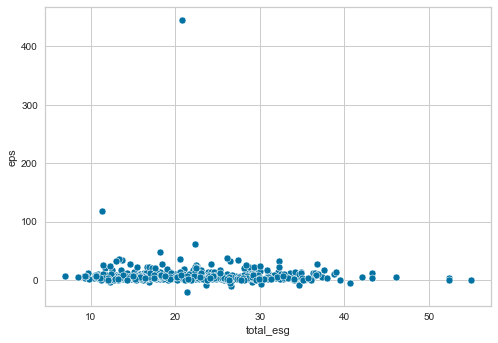

In [ ]:
#Detect the outlier based on the relationship between eps and total_esg
sns.scatterplot(data=df_all, x="total_esg", y="eps")

In [ ]:
#Identify the outlier
print(df_all['eps'].idxmax())

NVR


In [ ]:
#Drop the outlier
df_all = df_all.drop('NVR')

<AxesSubplot:xlabel='total_esg', ylabel='pe_ratio'>

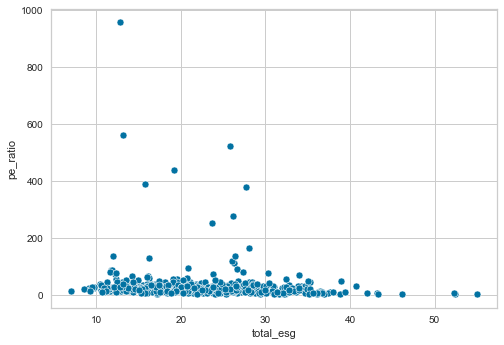

In [ ]:
#Detect the outlier based on the relationship between pe ratio and total_esg
sns.scatterplot(data=df_all, x="total_esg", y="pe_ratio")

In [ ]:
#Identify the outlier
print(df_all['pe_ratio'].idxmax())

VTR


In [ ]:
#Drop the outlier
df_all = df_all.drop('VTR')

<AxesSubplot:xlabel='total_esg', ylabel='profit_margin'>

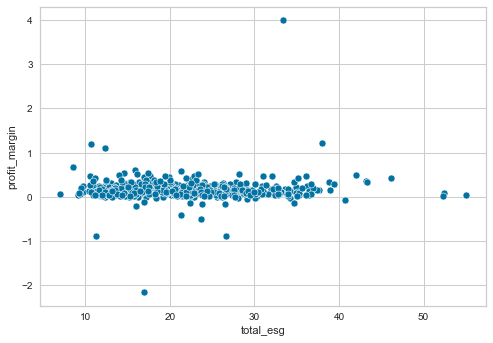

In [ ]:
#Detect the outlier based on the relationship between profit margin and total_esg
sns.scatterplot(data=df_all, x="total_esg", y="profit_margin")

In [ ]:
#Identify the outlier
print(df_all['profit_margin'].idxmax())

0006.HK


In [ ]:
#Drop the outlier
df_all = df_all.drop('0006.HK')

In [ ]:
df_all

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
Ticker,,,,,,,,,,
MMM,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3
AOS,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0
ABT,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3
ABBV,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3
ACN,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...
2319.HK,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0
9618.HK,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2
9888.HK,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3


In [ ]:
#Standardization - To put different variables on the same scale
scaler = StandardScaler()
df_tr = scaler.fit_transform(df_all)
df_tr = pd.DataFrame(df_tr, index=df_all.index, columns=df_all.columns)

#Transformed dataset
df_tr

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
Ticker,,,,,,,,,,
MMM,-0.064269,0.176391,-0.385242,-0.152710,0.497084,1.499340,1.212300,1.113589,0.281065,1.148941
AOS,0.486550,-0.124289,-0.216487,-0.129240,-0.427038,0.275020,0.250734,0.410734,-0.330839,-1.840340
ABT,-0.824764,0.105574,-0.101665,-0.075315,-0.283755,0.376505,-0.504123,1.121342,0.545673,1.148941
ABBV,-0.928769,0.393360,-0.164135,-0.152243,0.057237,0.748615,-0.856636,1.943062,1.203057,1.148941
ACN,0.473728,-0.209929,-0.125707,-0.043095,0.462651,-1.610251,-1.009822,-1.206867,-0.913803,0.152514
...,...,...,...,...,...,...,...,...,...,...
2319.HK,-0.855048,-0.454768,-0.160990,0.257244,-0.590315,1.550083,1.623873,0.893947,-0.132384,-1.840340
9618.HK,-1.388894,-0.772962,6.907518,-0.053480,-0.702498,0.736905,0.516503,0.330629,0.669708,0.152514
9888.HK,-0.920448,-0.606403,0.035045,-0.480881,0.094690,-0.177757,-0.511506,0.010210,0.578749,1.148941


# Task 4: Determine the number of clusters

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are l

Text(0, 0.5, 'Distortion')

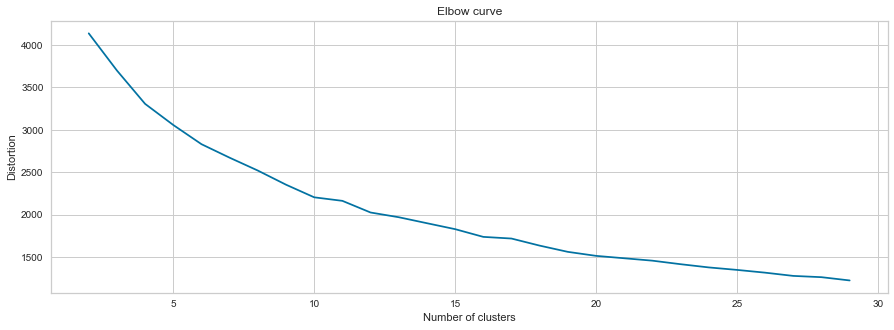

In [ ]:
#Elbow Curve - Determine the number of clusters
X = df_tr
distorsions = []
for k in range(2, 30):
    k_means = KMeans(n_clusters=k, random_state=0)
    k_means.fit(X)
    distorsions.append(k_means.inertia_)
fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 30), distorsions)
plt.grid(True)
plt.title('Elbow curve')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are l

Text(0.5, 0, 'Silhoette Coefficient Values')

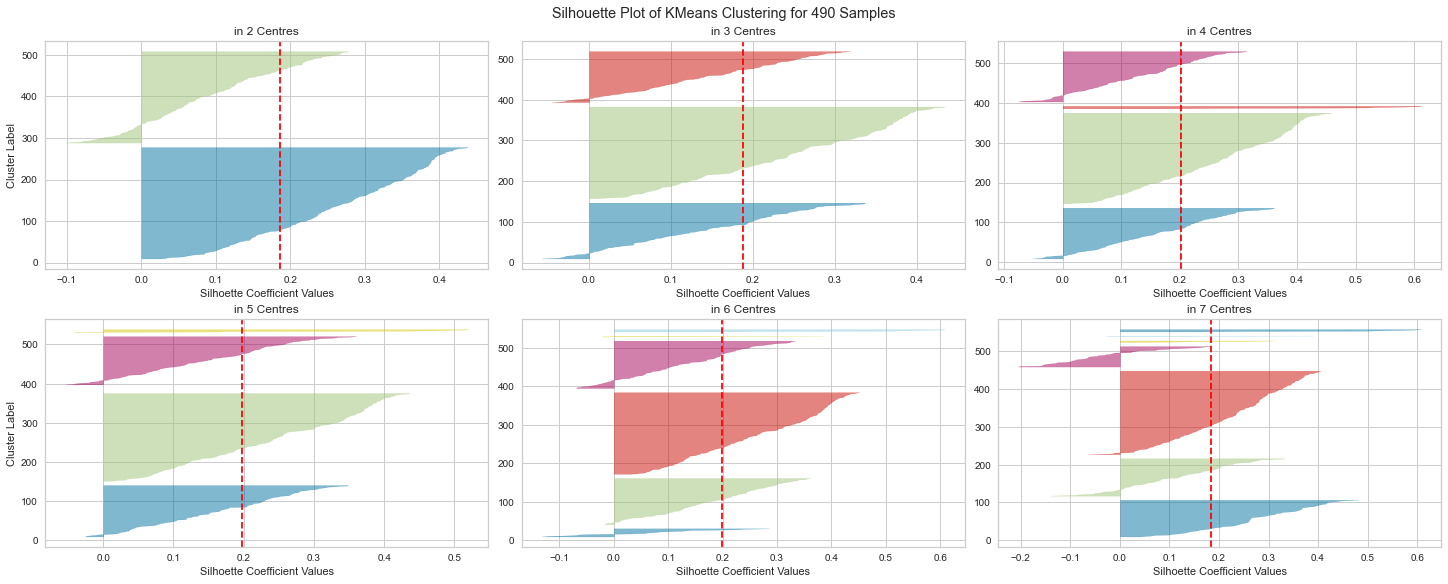

In [ ]:
#SilhouetteVisualizer
fig, ax = plt.subplots(2, 3, figsize=(20,8), constrained_layout=True)
fig.suptitle('Silhouette Plot of KMeans Clustering for 490 Samples')

model = SilhouetteVisualizer(KMeans(2), colors='yellowbrick', ax=ax[0][0])
model.fit(X)
ax[0][0].set_title('in 2 Centres')
ax[0][0].set_xlabel('Silhoette Coefficient Values')
ax[0][0].set_ylabel('Cluster Label')


model = SilhouetteVisualizer(KMeans(3), colors='yellowbrick', ax=ax[0][1])
model.fit(X)
ax[0][1].set_title('in 3 Centres')
ax[0][1].set_xlabel('Silhoette Coefficient Values')



model = SilhouetteVisualizer(KMeans(4), colors='yellowbrick', ax=ax[0][2])
model.fit(X)
ax[0][2].set_title('in 4 Centres')
ax[0][2].set_xlabel('Silhoette Coefficient Values')



model = SilhouetteVisualizer(KMeans(5), colors='yellowbrick', ax=ax[1][0])
model.fit(X)
ax[1][0].set_title('in 5 Centres')
ax[1][0].set_xlabel('Silhoette Coefficient Values')
ax[1][0].set_ylabel('Cluster Label')


model = SilhouetteVisualizer(KMeans(6), colors='yellowbrick', ax=ax[1][1])
model.fit(X)
ax[1][1].set_title('in 6 Centres')
ax[1][1].set_xlabel('Silhoette Coefficient Values')



model = SilhouetteVisualizer(KMeans(7), colors='yellowbrick', ax=ax[1][2])
model.fit(X)
ax[1][2].set_title('in 7 Centres')
ax[1][2].set_xlabel('Silhoette Coefficient Values')


#model.show();





1. Based on elbow curve, the slope with less than 5 clusters seems the steepest, followed by the one from 5 to 10 clusters
2. Based on Silhouette analysis, 2-5 clusters are more optimal with more uniform thickness and less negative values while 6-7 clusters have larger proportion of negative values
3. For the plots with >= 5 centres, one centre disappears}
4. 3 Clusters seems the most optimal: 1) all abover average 2) unfirom thickness 3) smallest proportion of negative values



Interpretation:

The value of the Silhouette score varies from -1 to 1. If the score is 1, the cluster is dense and well-separated than other clusters. A value near 0 represents overlapping clusters with samples very close to the decision boundary of the neighboring clusters. A negative score [-1, 0] indicates that the samples might have got assigned to the wrong clusters.

# Task 5: Determine the number of clusters

In [ ]:
stock_df.set_index('Ticker', inplace= True)

In [ ]:
stock_df

,Company,Sector,Country
Ticker,,,
MMM,3M,Industrials,USA
AOS,A. O. Smith,Industrials,USA
ABT,Abbott,Health Care,USA
ABBV,AbbVie,Health Care,USA
ACN,Accenture,Information Technology,USA
...,...,...,...
9618.HK,JD.com,Commerce & Industry,Hong Kong
9633.HK,Nongfu Spring,Commerce & Industry,Hong Kong
9888.HK,Baidu,Commerce & Industry,Hong Kong


In [ ]:
#combine for further analysis
df_all = pd.merge(stock_df, df_all, on='Ticker', how='inner')
df_all

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy
Ticker,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2
9888.HK,Baidu,Commerce & Industry,Hong Kong,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3


## Tasl 5.1: 2 Clusters

In [ ]:
k_means = KMeans(n_clusters=2, random_state=0)
k_means.fit(df_tr)
label = k_means.labels_
centroids = k_means.cluster_centers_

#Getting unique labels
u_labels = np.unique(label)

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [ ]:
centroids

array([[ 0.06462891,  0.01688445,  0.07016074,  0.00442994, -0.01081907,
        -0.69514724, -0.39143864, -0.58849331, -0.37628824, -0.35489129],
       [-0.07997459, -0.02089355, -0.08681991, -0.0054818 ,  0.01338799,
         0.86020503,  0.48438298,  0.72822688,  0.46563521,  0.43915772]])

In [ ]:
df_tr.columns

Index(['beta', 'profit_margin', 'pe_ratio', 'ev/ebita', 'eps', 'total_esg',
       'e_esg', 's_esg', 'g_esg', 'highestControversy'],
      dtype='object')

In [ ]:
#Characteristics of each cluster
df_2centroids=pd.DataFrame(centroids,columns=['beta', 'profit_margin', 'pe_ratio', 'ev/ebita', 'eps', 'total_esg', 'e_esg','s_esg', 'g_esg', 'highestControversy'])
df_2centroids['Cluster']=df_2centroids.index
df_2centroids

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
0,0.064629,0.016884,0.070161,0.004430,-0.010819,-0.695147,-0.391439,-0.588493,-0.376288,-0.354891,0
1,-0.079975,-0.020894,-0.086820,-0.005482,0.013388,0.860205,0.484383,0.728227,0.465635,0.439158,1


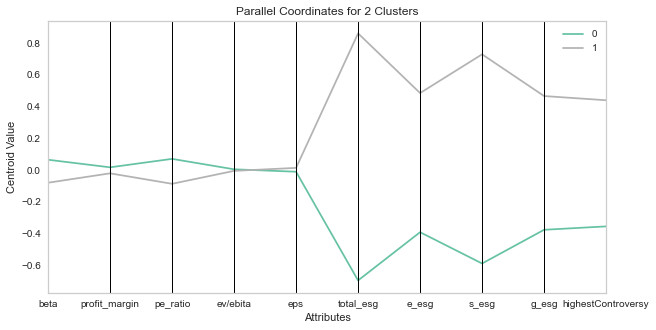

In [ ]:
#Parallel Coordinate Chart for
plt.figure(figsize=(10, 5))
plt.title('Parallel Coordinates for 2 Clusters')
plt.xlabel('Attributes')
plt.ylabel('Centroid Value')
pd.plotting.parallel_coordinates(df_2centroids,'Cluster', colormap=plt.get_cmap("Set2"));

In [ ]:
details_2clusters = [(name,cluster) for name, cluster in zip(df_all.index,label)]
for detail in details_2clusters:
    print(detail)

('MMM', 1)
('AOS', 0)
('ABT', 1)
('ABBV', 1)
('ACN', 0)
('ATVI', 1)
('ADM', 1)
('ADBE', 0)
('ADP', 0)
('AAP', 0)
('AES', 1)
('AFL', 0)
('A', 0)
('APD', 0)
('AKAM', 0)
('ALB', 1)
('ARE', 0)
('ALLE', 0)
('LNT', 0)
('ALL', 0)
('GOOGL', 1)
('MO', 1)
('AMZN', 1)
('AEE', 1)
('AAL', 1)
('AEP', 1)
('AXP', 0)
('AIG', 1)
('AMT', 0)
('AWK', 1)
('AMP', 1)
('ABC', 0)
('AME', 0)
('AMGN', 1)
('APH', 0)
('ADI', 0)
('ANSS', 0)
('APA', 1)
('AAPL', 0)
('AMAT', 0)
('APTV', 0)
('ACGL', 1)
('ANET', 0)
('AJG', 1)
('AIZ', 1)
('T', 1)
('ATO', 1)
('ADSK', 0)
('AZO', 0)
('AVB', 0)
('AVY', 0)
('BALL', 0)
('BAC', 1)
('BBWI', 0)
('BAX', 1)
('BDX', 1)
('WRB', 0)
('BBY', 0)
('BIO', 0)
('BIIB', 1)
('BLK', 0)
('BK', 1)
('BA', 1)
('BKNG', 1)
('BWA', 0)
('BXP', 0)
('BSX', 1)
('BMY', 1)
('AVGO', 1)
('BR', 0)
('BRO', 0)
('CHRW', 0)
('CDNS', 0)
('CPT', 0)
('CPB', 0)
('COF', 1)
('CAH', 0)
('KMX', 0)
('CCL', 1)
('CAT', 1)
('CBOE', 0)
('CBRE', 0)
('CDW', 0)
('CE', 1)
('CNC', 1)
('CNP', 1)
('CF', 1)
('SCHW', 1)
('CHTR', 1)
('CV

In [ ]:
df_all['Cluster'] = label
df_all

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3,1
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0,0
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,1
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,1
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0,1
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2,1
9888.HK,Baidu,Commerce & Industry,Hong Kong,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3,1


In [ ]:
for i in u_labels:
    print('Cluster',i,':',(df_all['Cluster']==i).sum())

Cluster 0 : 271
Cluster 1 : 219


In [ ]:
#Display Cluster 0
twoCluster_0 = df_all.loc[df_all['Cluster']==0]
twoCluster_0.to_csv('twoCluster_0.csv')
twoCluster_0

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0,0
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.15,9.71,0.29,4.58,4.83,2,0
ADBE,Adobe Inc.,Information Technology,USA,1.257183,0.27014,33.010914,22.623,10.08,12.46,1.89,5.93,4.64,1,0
ADP,ADP,Information Technology,USA,0.864318,0.17933,33.263160,22.044,7.22,13.97,1.07,6.96,5.94,1,0
AAP,Advance Auto Parts,Consumer Discretionary,USA,1.138821,0.04304,19.746155,12.736,7.80,12.97,0.10,9.17,3.70,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0669.HK,Techtronic Industries,Commerce & Industry,Hong Kong,1.425098,0.08332,18.061224,111.737,4.90,22.87,8.91,8.06,5.89,1,0
0992.HK,Lenovo,Commerce & Industry,Hong Kong,1.208627,0.02976,4.945737,18.538,1.29,15.25,0.17,7.49,7.59,2,0
2020.HK,Anta Sports,Commerce & Industry,Hong Kong,0.852549,0.14230,34.169384,24.267,3.07,17.42,1.62,8.47,7.34,2,0


In [ ]:
df_all.loc[df_all['Cluster']==0].index.to_list()

['AOS',
 'ACN',
 'ADBE',
 'ADP',
 'AAP',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ARE',
 'ALLE',
 'LNT',
 'ALL',
 'AXP',
 'AMT',
 'ABC',
 'AME',
 'APH',
 'ADI',
 'ANSS',
 'AAPL',
 'AMAT',
 'APTV',
 'ANET',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BALL',
 'BBWI',
 'WRB',
 'BBY',
 'BIO',
 'BLK',
 'BWA',
 'BXP',
 'BR',
 'BRO',
 'CHRW',
 'CDNS',
 'CPT',
 'CPB',
 'CAH',
 'KMX',
 'CBOE',
 'CBRE',
 'CDW',
 'CHD',
 'CI',
 'CTAS',
 'CSCO',
 'CLX',
 'CME',
 'CMS',
 'CTSH',
 'STZ',
 'COO',
 'CPRT',
 'GLW',
 'CCI',
 'CSX',
 'CMI',
 'DHI',
 'DHR',
 'DE',
 'XRAY',
 'DXCM',
 'DLR',
 'DIS',
 'DG',
 'DLTR',
 'DXC',
 'EMN',
 'ETN',
 'EBAY',
 'EW',
 'EA',
 'ELV',
 'EQIX',
 'EQR',
 'ESS',
 'RE',
 'ES',
 'EXPD',
 'EXR',
 'FFIV',
 'FDS',
 'FRT',
 'FDX',
 'FITB',
 'FIS',
 'FISV',
 'FLT',
 'FTNT',
 'BEN',
 'GRMN',
 'IT',
 'GIS',
 'GPC',
 'GL',
 'GPN',
 'HAL',
 'HIG',
 'HAS',
 'PEAK',
 'HSIC',
 'HPE',
 'HLT',
 'HD',
 'HST',
 'HPQ',
 'HBAN',
 'IBM',
 'IDXX',
 'ITW',
 'ILMN',
 'INTC',
 'ICE',
 'IPG',
 'IFF',
 'INTU',
 'ISRG',

In [ ]:
#Display Cluster 1
twoCluster_1 = df_all.loc[df_all['Cluster']==1]
twoCluster_1.to_csv('twoCluster_1.csv')
twoCluster_1

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3,1
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,1
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,1
ATVI,Activision Blizzard,Communication Services,USA,0.427624,0.22754,36.427227,24.337,2.130000,18.94,0.15,12.48,6.31,4,1
ADM,ADM,Consumer Staples,USA,0.844109,0.04157,12.278571,10.672,7.000000,36.40,18.23,13.16,5.01,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211.HK,BYD Company,Commerce & Industry,Hong Kong,0.542745,0.02927,52.299740,22.239,3.870000,24.05,6.33,7.28,10.44,2,1
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0,1
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2,1


In [ ]:
twoCluster_1.index.to_list()

['MMM',
 'ABT',
 'ABBV',
 'ATVI',
 'ADM',
 'AES',
 'ALB',
 'GOOGL',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AIG',
 'AWK',
 'AMP',
 'AMGN',
 'APA',
 'ACGL',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'BAC',
 'BAX',
 'BDX',
 'BIIB',
 'BK',
 'BA',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'COF',
 'CCL',
 'CAT',
 'CE',
 'CNC',
 'CNP',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CINF',
 'C',
 'CFG',
 'KO',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 'CSGP',
 'COST',
 'CTRA',
 'CVS',
 'DRI',
 'DVA',
 'DAL',
 'DVN',
 'DFS',
 'DISH',
 'D',
 'DPZ',
 'DOV',
 'DTE',
 'DUK',
 'DD',
 'ECL',
 'EIX',
 'LLY',
 'EMR',
 'ETR',
 'EOG',
 'EQT',
 'EFX',
 'EL',
 'EXC',
 'EXPE',
 'XOM',
 'FAST',
 'FRC',
 'FE',
 'FMC',
 'F',
 'FTV',
 'FCX',
 'GD',
 'GE',
 'GM',
 'GILD',
 'GS',
 'HCA',
 'HSY',
 'HES',
 'HOLX',
 'HON',
 'HRL',
 'HUM',
 'IEX',
 'INCY',
 'IP',
 'J',
 'JNJ',
 'JPM',
 'K',
 'KEY',
 'KHC',
 'KR',
 'LMT',
 'LUMN',
 'MTB',
 'MRO',
 'MPC',
 'MLM',
 'MKC',
 'MCD',
 'MDT',
 'MRK',
 'META',
 'MGM',
 'MCHP',
 'M

## Task 5.2: 3 Clusters

In [ ]:
k_means = KMeans(n_clusters=3, random_state=0)
k_means.fit(df_tr)
label = k_means.labels_
centroids = k_means.cluster_centers_

#Getting unique labels
u_labels = np.unique(label)

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [ ]:
centroids

array([[-0.10549064,  0.05348198, -0.15312931, -0.0992552 ,  0.05181258,
         0.85137645,  0.4567429 ,  0.73120072,  0.49446773,  0.4280241 ],
       [-0.18909664, -0.66456912,  5.46029237,  3.54334917, -0.67717309,
        -0.03255632, -0.23946198,  0.10271786,  0.28354616, -0.44534186],
       [ 0.09422979, -0.01885893, -0.08126944, -0.05283313, -0.01700228,
        -0.70122862, -0.36775129, -0.60721572, -0.4187641 , -0.33622742]])

In [ ]:
#Characteristics of each cluster
df_3centroids=pd.DataFrame(centroids,columns=['beta', 'profit_margin', 'pe_ratio', 'ev/ebita', 'eps', 'total_esg', 'e_esg','s_esg', 'g_esg', 'highestControversy'])
df_3centroids['Cluster']=df_3centroids.index
df_3centroids

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
0,-0.105491,0.053482,-0.153129,-0.099255,0.051813,0.851376,0.456743,0.731201,0.494468,0.428024,0
1,-0.189097,-0.664569,5.460292,3.543349,-0.677173,-0.032556,-0.239462,0.102718,0.283546,-0.445342,1
2,0.094230,-0.018859,-0.081269,-0.052833,-0.017002,-0.701229,-0.367751,-0.607216,-0.418764,-0.336227,2


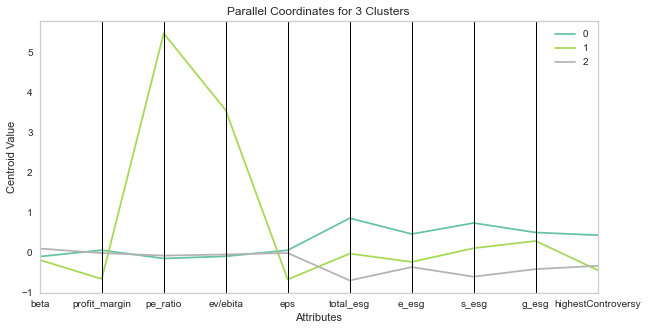

In [ ]:
#Parallel Coordinate Chart for 3 clusters
plt.figure(figsize=(10, 5))
plt.title('Parallel Coordinates for 3 Clusters')
plt.xlabel('Attributes')
plt.ylabel('Centroid Value')
pd.plotting.parallel_coordinates(df_3centroids,'Cluster', colormap=plt.get_cmap("Set2"));

In [ ]:
details_3clusters = [(name,cluster) for name, cluster in zip(df_all.index,label)]
for detail in details_3clusters:
    print(detail)

('MMM', 0)
('AOS', 2)
('ABT', 0)
('ABBV', 0)
('ACN', 2)
('ATVI', 0)
('ADM', 0)
('ADBE', 2)
('ADP', 2)
('AAP', 2)
('AES', 0)
('AFL', 2)
('A', 2)
('APD', 2)
('AKAM', 2)
('ALB', 0)
('ARE', 2)
('ALLE', 2)
('LNT', 2)
('ALL', 2)
('GOOGL', 0)
('MO', 0)
('AMZN', 0)
('AEE', 0)
('AAL', 0)
('AEP', 0)
('AXP', 2)
('AIG', 0)
('AMT', 2)
('AWK', 0)
('AMP', 0)
('ABC', 2)
('AME', 2)
('AMGN', 0)
('APH', 2)
('ADI', 2)
('ANSS', 2)
('APA', 0)
('AAPL', 2)
('AMAT', 2)
('APTV', 2)
('ACGL', 0)
('ANET', 2)
('AJG', 0)
('AIZ', 0)
('T', 0)
('ATO', 0)
('ADSK', 2)
('AZO', 2)
('AVB', 2)
('AVY', 2)
('BALL', 2)
('BAC', 0)
('BBWI', 2)
('BAX', 0)
('BDX', 0)
('WRB', 0)
('BBY', 2)
('BIO', 2)
('BIIB', 0)
('BLK', 0)
('BK', 0)
('BA', 0)
('BKNG', 0)
('BWA', 2)
('BXP', 2)
('BSX', 0)
('BMY', 0)
('AVGO', 0)
('BR', 2)
('BRO', 2)
('CHRW', 2)
('CDNS', 2)
('CPT', 2)
('CPB', 2)
('COF', 0)
('CAH', 2)
('KMX', 2)
('CCL', 2)
('CAT', 0)
('CBOE', 2)
('CBRE', 2)
('CDW', 2)
('CE', 0)
('CNC', 0)
('CNP', 0)
('CF', 0)
('SCHW', 0)
('CHTR', 0)
('CV

In [ ]:
df_all['Cluster'] = label
df_all

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3,0
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0,2
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,0
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,0
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0,0
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2,1
9888.HK,Baidu,Commerce & Industry,Hong Kong,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3,0


In [ ]:
for i in u_labels:
    print('Cluster',i,':',(df_all['Cluster']==i).sum())

Cluster 0 : 217
Cluster 1 : 10
Cluster 2 : 263


In [ ]:
#Display Cluster 0
threeCluster_0 = df_all.loc[df_all['Cluster']==0]
threeCluster_0.to_csv('threeCluster_0.csv')
threeCluster_0

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3,0
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,0
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,0
ATVI,Activision Blizzard,Communication Services,USA,0.427624,0.22754,36.427227,24.337,2.130000,18.94,0.15,12.48,6.31,4,0
ADM,ADM,Consumer Staples,USA,0.844109,0.04157,12.278571,10.672,7.000000,36.40,18.23,13.16,5.01,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177.HK,Sino Biopharm,Commerce & Industry,Hong Kong,0.537647,0.29057,10.545454,17.544,0.440000,39.45,4.60,20.52,14.33,0,0
1211.HK,BYD Company,Commerce & Industry,Hong Kong,0.542745,0.02927,52.299740,22.239,3.870000,24.05,6.33,7.28,10.44,2,0
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0,0


In [ ]:
threeCluster_0.index.to_list()

['MMM',
 'ABT',
 'ABBV',
 'ATVI',
 'ADM',
 'AES',
 'ALB',
 'GOOGL',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AIG',
 'AWK',
 'AMP',
 'AMGN',
 'APA',
 'ACGL',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'BAC',
 'BAX',
 'BDX',
 'WRB',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'COF',
 'CAT',
 'CE',
 'CNC',
 'CNP',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'C',
 'CFG',
 'KO',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 'CSGP',
 'COST',
 'CTRA',
 'CVS',
 'DRI',
 'DVA',
 'DVN',
 'DFS',
 'DISH',
 'D',
 'DPZ',
 'DOV',
 'DTE',
 'DUK',
 'DD',
 'ECL',
 'EIX',
 'LLY',
 'EMR',
 'ETR',
 'EOG',
 'EQT',
 'EFX',
 'EL',
 'EXC',
 'EXPE',
 'XOM',
 'FAST',
 'FRC',
 'FE',
 'FMC',
 'F',
 'FTV',
 'FCX',
 'GD',
 'GE',
 'GM',
 'GILD',
 'GS',
 'HCA',
 'HSY',
 'HES',
 'HOLX',
 'HON',
 'HRL',
 'HUM',
 'IEX',
 'INCY',
 'ISRG',
 'J',
 'JNJ',
 'JPM',
 'K',
 'KEY',
 'KHC',
 'KR',
 'LMT',
 'LUMN',
 'MTB',
 'MRO',
 'MPC',
 'MLM',
 'MKC',
 'MCD',
 'MDT',
 'MRK',
 'META',
 'MGM',
 'MCHP',
 'MDLZ',
 

In [ ]:
#Display Cluster 1
threeCluster_1 = df_all.loc[df_all['Cluster']==1]
threeCluster_1.to_csv('threeCluster_1.csv')
threeCluster_1

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
CINF,Cincinnati Financial,Financials,USA,0.643529,-0.00429,34.186916,662.834,3.21,25.62,1.82,10.97,12.83,1,1
STZ,Constellation Brands,Consumer Staples,USA,0.984554,0.01107,522.512200,15.192,0.41,25.79,10.35,10.04,5.40,2,1
DAL,Delta Air Lines,Industrials,USA,1.221485,0.00174,277.153840,10.178,0.13,26.13,9.52,11.46,5.15,2,1
DXCM,Dexcom,Health Care,USA,1.159051,0.06513,251.782610,105.478,0.46,23.72,5.39,10.24,8.09,0,1
GPN,Global Payments,Information Technology,USA,0.972445,0.00792,438.208340,10.966,0.24,19.18,1.31,10.92,6.95,2,1
CRM,Salesforce,Information Technology,USA,1.129403,0.00918,562.040000,53.822,0.25,13.18,2.34,6.39,4.46,2,1
NOW,ServiceNow,Information Technology,USA,0.959888,0.02905,389.925540,106.952,0.94,15.73,1.41,8.39,5.94,1,1
1299.HK,AIA Group Limited,Financials,Hong Kong,0.920000,0.14304,38.854626,292.200,2.27,13.16,0.56,6.32,6.28,2,1
0027.HK,Galaxy Entertainment Group Ltd.,Commerce & Industry,Hong Kong,0.919215,-0.03015,164.677410,266.863,0.31,28.10,3.38,11.22,13.50,0,1


In [ ]:
threeCluster_1.index.to_list()

['CINF',
 'STZ',
 'DAL',
 'DXCM',
 'GPN',
 'CRM',
 'NOW',
 '1299.HK',
 '0027.HK',
 '9618.HK']

In [ ]:
#Display Cluster 2
threeCluster_2 = df_all.loc[df_all['Cluster']==2]
threeCluster_2.to_csv('threeCluster_2.csv')
threeCluster_2

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0,2
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.15,9.71,0.29,4.58,4.83,2,2
ADBE,Adobe Inc.,Information Technology,USA,1.257183,0.27014,33.010914,22.623,10.08,12.46,1.89,5.93,4.64,1,2
ADP,ADP,Information Technology,USA,0.864318,0.17933,33.263160,22.044,7.22,13.97,1.07,6.96,5.94,1,2
AAP,Advance Auto Parts,Consumer Discretionary,USA,1.138821,0.04304,19.746155,12.736,7.80,12.97,0.10,9.17,3.70,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0669.HK,Techtronic Industries,Commerce & Industry,Hong Kong,1.425098,0.08332,18.061224,111.737,4.90,22.87,8.91,8.06,5.89,1,2
0992.HK,Lenovo,Commerce & Industry,Hong Kong,1.208627,0.02976,4.945737,18.538,1.29,15.25,0.17,7.49,7.59,2,2
2020.HK,Anta Sports,Commerce & Industry,Hong Kong,0.852549,0.14230,34.169384,24.267,3.07,17.42,1.62,8.47,7.34,2,2


In [ ]:
threeCluster_2.index.to_list()

['AOS',
 'ACN',
 'ADBE',
 'ADP',
 'AAP',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ARE',
 'ALLE',
 'LNT',
 'ALL',
 'AXP',
 'AMT',
 'ABC',
 'AME',
 'APH',
 'ADI',
 'ANSS',
 'AAPL',
 'AMAT',
 'APTV',
 'ANET',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BALL',
 'BBWI',
 'BBY',
 'BIO',
 'BWA',
 'BXP',
 'BR',
 'BRO',
 'CHRW',
 'CDNS',
 'CPT',
 'CPB',
 'CAH',
 'KMX',
 'CCL',
 'CBOE',
 'CBRE',
 'CDW',
 'CHD',
 'CI',
 'CTAS',
 'CSCO',
 'CLX',
 'CME',
 'CMS',
 'CTSH',
 'COO',
 'CPRT',
 'GLW',
 'CCI',
 'CSX',
 'CMI',
 'DHI',
 'DHR',
 'DE',
 'XRAY',
 'DLR',
 'DIS',
 'DG',
 'DLTR',
 'DXC',
 'EMN',
 'ETN',
 'EBAY',
 'EW',
 'EA',
 'ELV',
 'EQIX',
 'EQR',
 'ESS',
 'RE',
 'ES',
 'EXPD',
 'EXR',
 'FFIV',
 'FDS',
 'FRT',
 'FDX',
 'FITB',
 'FIS',
 'FISV',
 'FLT',
 'FTNT',
 'BEN',
 'GRMN',
 'IT',
 'GIS',
 'GPC',
 'GL',
 'HAL',
 'HIG',
 'HAS',
 'PEAK',
 'HSIC',
 'HPE',
 'HLT',
 'HD',
 'HST',
 'HPQ',
 'HBAN',
 'IBM',
 'IDXX',
 'ITW',
 'ILMN',
 'INTC',
 'ICE',
 'IP',
 'IPG',
 'IFF',
 'INTU',
 'IVZ',
 'IQV',
 'IRM',
 'JBHT',
 

# Task 5.3 4 Clusters

In [ ]:
k_means = KMeans(n_clusters=4, random_state=0)
k_means.fit(df_tr)
label = k_means.labels_
centroids = k_means.cluster_centers_

#Getting unique labels
u_labels = np.unique(label)

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [ ]:
centroids

array([[ 0.04755985, -0.02047174, -0.07025266, -0.04539426, -0.01317382,
        -0.794088  , -0.40914831, -0.67188132, -0.5177036 , -0.42132085],
       [-0.21125513,  0.21683343, -0.10366578, -0.02333461,  0.17987122,
         0.29110617, -0.60751501,  0.78202128,  1.01981584,  0.48465666],
       [-0.18909664, -0.66456912,  5.46029237,  3.54334917, -0.67717309,
        -0.03255632, -0.23946198,  0.10271786,  0.28354616, -0.44534186],
       [ 0.15421966, -0.1402472 , -0.20308422, -0.17891137, -0.11306722,
         1.12721984,  1.4051276 ,  0.37296313, -0.17327052,  0.28108556]])

In [ ]:
#Characteristics of each cluster
df_4centroids=pd.DataFrame(centroids,columns=['beta','profit_margin', 'pe_ratio', 'ev/ebita', 'eps', 'total_esg', 'e_esg','s_esg', 'g_esg', 'highestControversy'])
df_4centroids['Cluster']=df_4centroids.index
df_4centroids

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
0,0.047560,-0.020472,-0.070253,-0.045394,-0.013174,-0.794088,-0.409148,-0.671881,-0.517704,-0.421321,0
1,-0.211255,0.216833,-0.103666,-0.023335,0.179871,0.291106,-0.607515,0.782021,1.019816,0.484657,1
2,-0.189097,-0.664569,5.460292,3.543349,-0.677173,-0.032556,-0.239462,0.102718,0.283546,-0.445342,2
3,0.154220,-0.140247,-0.203084,-0.178911,-0.113067,1.127220,1.405128,0.372963,-0.173271,0.281086,3


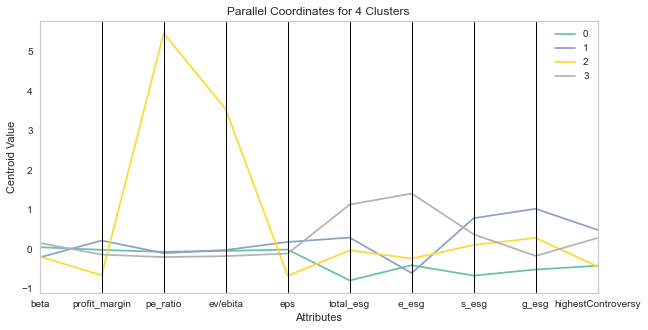

In [ ]:
#Parallel Coordinate Chart for 4 clusters
plt.figure(figsize=(10, 5))
plt.title('Parallel Coordinates for 4 Clusters')
plt.xlabel('Attributes')
plt.ylabel('Centroid Value')
pd.plotting.parallel_coordinates(df_4centroids,'Cluster', colormap=plt.get_cmap("Set2"));

#Similar financial performance but different levels of esg performance (good normal bad ???)

In [ ]:
details_4clusters = [(name,cluster) for name, cluster in zip(df_all.index,label)]
for detail in details_4clusters:
    print(detail)

('MMM', 3)
('AOS', 0)
('ABT', 1)
('ABBV', 1)
('ACN', 0)
('ATVI', 1)
('ADM', 3)
('ADBE', 0)
('ADP', 0)
('AAP', 0)
('AES', 3)
('AFL', 1)
('A', 0)
('APD', 0)
('AKAM', 0)
('ALB', 3)
('ARE', 0)
('ALLE', 0)
('LNT', 0)
('ALL', 1)
('GOOGL', 1)
('MO', 1)
('AMZN', 1)
('AEE', 3)
('AAL', 3)
('AEP', 3)
('AXP', 1)
('AIG', 1)
('AMT', 0)
('AWK', 3)
('AMP', 1)
('ABC', 0)
('AME', 0)
('AMGN', 1)
('APH', 0)
('ADI', 0)
('ANSS', 0)
('APA', 3)
('AAPL', 1)
('AMAT', 0)
('APTV', 0)
('ACGL', 1)
('ANET', 0)
('AJG', 1)
('AIZ', 1)
('T', 1)
('ATO', 3)
('ADSK', 0)
('AZO', 0)
('AVB', 0)
('AVY', 0)
('BALL', 0)
('BAC', 1)
('BBWI', 0)
('BAX', 1)
('BDX', 1)
('WRB', 1)
('BBY', 0)
('BIO', 0)
('BIIB', 1)
('BLK', 1)
('BK', 1)
('BA', 3)
('BKNG', 1)
('BWA', 0)
('BXP', 0)
('BSX', 1)
('BMY', 1)
('AVGO', 1)
('BR', 0)
('BRO', 1)
('CHRW', 0)
('CDNS', 0)
('CPT', 0)
('CPB', 0)
('COF', 1)
('CAH', 0)
('KMX', 0)
('CCL', 3)
('CAT', 1)
('CBOE', 0)
('CBRE', 0)
('CDW', 0)
('CE', 3)
('CNC', 1)
('CNP', 3)
('CF', 3)
('SCHW', 1)
('CHTR', 1)
('CV

In [ ]:
df_all['Cluster'] = label
df_all

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3,3
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0,0
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,1
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,1
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0,3
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2,2
9888.HK,Baidu,Commerce & Industry,Hong Kong,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3,1


In [ ]:
for i in u_labels:
    print('Cluster',i,':',(df_all['Cluster']==i).sum())

Cluster 0 : 224
Cluster 1 : 132
Cluster 2 : 10
Cluster 3 : 124


In [ ]:
#Display Cluster 0
fourCluster_0 = df_all.loc[df_all['Cluster']==0]
fourCluster_0.to_csv('fourCluster_0.csv')
fourCluster_0

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0,0
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.15,9.71,0.29,4.58,4.83,2,0
ADBE,Adobe Inc.,Information Technology,USA,1.257183,0.27014,33.010914,22.623,10.08,12.46,1.89,5.93,4.64,1,0
ADP,ADP,Information Technology,USA,0.864318,0.17933,33.263160,22.044,7.22,13.97,1.07,6.96,5.94,1,0
AAP,Advance Auto Parts,Consumer Discretionary,USA,1.138821,0.04304,19.746155,12.736,7.80,12.97,0.10,9.17,3.70,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0669.HK,Techtronic Industries,Commerce & Industry,Hong Kong,1.425098,0.08332,18.061224,111.737,4.90,22.87,8.91,8.06,5.89,1,0
0992.HK,Lenovo,Commerce & Industry,Hong Kong,1.208627,0.02976,4.945737,18.538,1.29,15.25,0.17,7.49,7.59,2,0
2020.HK,Anta Sports,Commerce & Industry,Hong Kong,0.852549,0.14230,34.169384,24.267,3.07,17.42,1.62,8.47,7.34,2,0


In [ ]:
df_all.loc[df_all['Cluster']==0].index.to_list()

['AOS',
 'ACN',
 'ADBE',
 'ADP',
 'AAP',
 'A',
 'APD',
 'AKAM',
 'ARE',
 'ALLE',
 'LNT',
 'AMT',
 'ABC',
 'AME',
 'APH',
 'ADI',
 'ANSS',
 'AMAT',
 'APTV',
 'ANET',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BALL',
 'BBWI',
 'BBY',
 'BIO',
 'BWA',
 'BXP',
 'BR',
 'CHRW',
 'CDNS',
 'CPT',
 'CPB',
 'CAH',
 'KMX',
 'CBOE',
 'CBRE',
 'CDW',
 'CHD',
 'CI',
 'CTAS',
 'CSCO',
 'CLX',
 'CME',
 'CMS',
 'CTSH',
 'COO',
 'CPRT',
 'GLW',
 'CCI',
 'CSX',
 'CMI',
 'DHI',
 'DHR',
 'DE',
 'XRAY',
 'DLR',
 'DIS',
 'DG',
 'DLTR',
 'DXC',
 'ETN',
 'EBAY',
 'EW',
 'EA',
 'ELV',
 'EQIX',
 'EQR',
 'ESS',
 'RE',
 'ES',
 'EXPD',
 'EXR',
 'FFIV',
 'FDS',
 'FRT',
 'FDX',
 'FIS',
 'FISV',
 'FLT',
 'FTNT',
 'BEN',
 'GRMN',
 'GIS',
 'GPC',
 'HIG',
 'HAS',
 'PEAK',
 'HSIC',
 'HPE',
 'HLT',
 'HD',
 'HST',
 'HPQ',
 'IBM',
 'IDXX',
 'ITW',
 'ILMN',
 'INTC',
 'ICE',
 'IPG',
 'IFF',
 'INTU',
 'IQV',
 'IRM',
 'JBHT',
 'JKHY',
 'JCI',
 'JNPR',
 'KEYS',
 'KMB',
 'KIM',
 'KMI',
 'KLAC',
 'KR',
 'LRCX',
 'LDOS',
 'LNC',
 'LKQ',
 'LO

In [ ]:
#Display Cluster 1
fourCluster_1 = df_all.loc[df_all['Cluster']==1]
fourCluster_1.to_csv('fourCluster_1.csv')
fourCluster_1

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,1
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,1
ATVI,Activision Blizzard,Communication Services,USA,0.427624,0.22754,36.427227,24.337,2.130000,18.94,0.15,12.48,6.31,4,1
AFL,Aflac,Financials,USA,0.935704,0.24154,9.491002,8.773,7.780000,17.30,0.47,7.26,9.57,2,1
ALL,Allstate,Financials,USA,0.636205,-0.00413,44.040497,32.825,3.210000,19.22,1.44,7.85,9.94,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093.HK,CSPC Pharmaceutical Group Ltd,Commerce & Industry,Hong Kong,0.752549,0.18677,16.769232,12.174,0.520000,34.01,3.36,18.43,12.22,0,1
1177.HK,Sino Biopharm,Commerce & Industry,Hong Kong,0.537647,0.29057,10.545454,17.544,0.440000,39.45,4.60,20.52,14.33,0,1
1211.HK,BYD Company,Commerce & Industry,Hong Kong,0.542745,0.02927,52.299740,22.239,3.870000,24.05,6.33,7.28,10.44,2,1


In [ ]:
df_all.loc[df_all['Cluster']==1].index.to_list()

['ABT',
 'ABBV',
 'ATVI',
 'AFL',
 'ALL',
 'GOOGL',
 'MO',
 'AMZN',
 'AXP',
 'AIG',
 'AMP',
 'AMGN',
 'AAPL',
 'ACGL',
 'AJG',
 'AIZ',
 'T',
 'BAC',
 'BAX',
 'BDX',
 'WRB',
 'BIIB',
 'BLK',
 'BK',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'BRO',
 'COF',
 'CAT',
 'CNC',
 'SCHW',
 'CHTR',
 'CMG',
 'CB',
 'C',
 'CFG',
 'CL',
 'CMCSA',
 'CMA',
 'ED',
 'CSGP',
 'CVS',
 'DVA',
 'DFS',
 'DISH',
 'LLY',
 'EFX',
 'EL',
 'EXPE',
 'FITB',
 'FRC',
 'IT',
 'GILD',
 'GL',
 'GS',
 'HCA',
 'HOLX',
 'HUM',
 'HBAN',
 'INCY',
 'ISRG',
 'IVZ',
 'J',
 'JNJ',
 'JPM',
 'KEY',
 'LH',
 'LVS',
 'LMT',
 'L',
 'LUMN',
 'MTB',
 'MMC',
 'MA',
 'MCD',
 'MDT',
 'MRK',
 'META',
 'MGM',
 'MS',
 'NTRS',
 'NOC',
 'PCAR',
 'PFE',
 'PM',
 'PNC',
 'PGR',
 'PWR',
 'DGX',
 'RJF',
 'REGN',
 'RMD',
 'SBNY',
 'SWK',
 'STT',
 'SYK',
 'SIVB',
 'TMUS',
 'TFX',
 'TSLA',
 'TRV',
 'USB',
 'UNH',
 'UHS',
 'VRSK',
 'VRTX',
 'V',
 'WMT',
 'WFC',
 'WTW',
 'WYNN',
 'ZBH',
 '0005.HK',
 '0011.HK',
 '0388.HK',
 '0939.HK',
 '1398.HK',
 '2388.HK',
 '2

In [ ]:
#Display Cluster 2
fourCluster_2 = df_all.loc[df_all['Cluster']==2]
fourCluster_2.to_csv("fourCluster_2.csv")
fourCluster_2

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
CINF,Cincinnati Financial,Financials,USA,0.643529,-0.00429,34.186916,662.834,3.21,25.62,1.82,10.97,12.83,1,2
STZ,Constellation Brands,Consumer Staples,USA,0.984554,0.01107,522.512200,15.192,0.41,25.79,10.35,10.04,5.40,2,2
DAL,Delta Air Lines,Industrials,USA,1.221485,0.00174,277.153840,10.178,0.13,26.13,9.52,11.46,5.15,2,2
DXCM,Dexcom,Health Care,USA,1.159051,0.06513,251.782610,105.478,0.46,23.72,5.39,10.24,8.09,0,2
GPN,Global Payments,Information Technology,USA,0.972445,0.00792,438.208340,10.966,0.24,19.18,1.31,10.92,6.95,2,2
CRM,Salesforce,Information Technology,USA,1.129403,0.00918,562.040000,53.822,0.25,13.18,2.34,6.39,4.46,2,2
NOW,ServiceNow,Information Technology,USA,0.959888,0.02905,389.925540,106.952,0.94,15.73,1.41,8.39,5.94,1,2
1299.HK,AIA Group Limited,Financials,Hong Kong,0.920000,0.14304,38.854626,292.200,2.27,13.16,0.56,6.32,6.28,2,2
0027.HK,Galaxy Entertainment Group Ltd.,Commerce & Industry,Hong Kong,0.919215,-0.03015,164.677410,266.863,0.31,28.10,3.38,11.22,13.50,0,2


In [ ]:
df_all.loc[df_all['Cluster']==2].index.to_list()

['CINF',
 'STZ',
 'DAL',
 'DXCM',
 'GPN',
 'CRM',
 'NOW',
 '1299.HK',
 '0027.HK',
 '9618.HK']

In [ ]:
#Display Cluster 3
fourCluster_3 = df_all.loc[df_all['Cluster']==3]
fourCluster_3.to_csv('fourCluster_3.csv')
fourCluster_3

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460,33.61,12.33,13.56,7.72,3,3
ADM,ADM,Consumer Staples,USA,0.844109,0.04157,12.278571,10.672,7.000,36.40,18.23,13.16,5.01,3,3
AES,AES Corporation,Utilities,USA,0.972701,-0.02231,32.250166,11.946,-0.223,34.15,16.48,11.20,6.47,2,3
ALB,Albemarle Corporation,Materials,USA,1.520404,0.27775,16.803640,13.170,13.190,28.80,15.53,5.54,7.73,2,3
AEE,Ameren,Utilities,USA,0.446110,0.14459,22.135338,13.153,3.990,29.44,14.11,9.84,5.49,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0857.HK,PetroChina Company Limited,Commerce & Industry,Hong Kong,0.797254,0.04305,4.223529,2.319,0.850,55.01,22.66,19.41,12.94,5,3
0883.HK,CNOOC Limited,Commerce & Industry,Hong Kong,0.928235,0.32929,3.703704,1.485,2.700,43.29,22.15,10.59,10.55,2,3
1044.HK,Hengan International Group Co. Ltd,Commerce & Industry,Hong Kong,0.484313,0.12216,15.914398,11.787,2.570,29.90,10.58,9.49,9.83,0,3


In [ ]:
df_all.loc[df_all['Cluster']==3].index.to_list()

['MMM',
 'ADM',
 'AES',
 'ALB',
 'AEE',
 'AAL',
 'AEP',
 'AWK',
 'APA',
 'ATO',
 'BA',
 'CCL',
 'CE',
 'CNP',
 'CF',
 'CVX',
 'KO',
 'CAG',
 'COP',
 'COST',
 'CTRA',
 'DRI',
 'DVN',
 'D',
 'DPZ',
 'DOV',
 'DTE',
 'DUK',
 'DD',
 'EMN',
 'ECL',
 'EIX',
 'EMR',
 'ETR',
 'EOG',
 'EQT',
 'EXC',
 'XOM',
 'FAST',
 'FE',
 'FMC',
 'F',
 'FTV',
 'FCX',
 'GD',
 'GE',
 'GM',
 'HAL',
 'HSY',
 'HES',
 'HON',
 'HRL',
 'IEX',
 'IP',
 'K',
 'KHC',
 'LEN',
 'LYB',
 'MRO',
 'MPC',
 'MAR',
 'MLM',
 'MAS',
 'MKC',
 'MCHP',
 'MDLZ',
 'MNST',
 'MOS',
 'NEE',
 'NI',
 'NDSN',
 'NSC',
 'NCLH',
 'NRG',
 'NUE',
 'OXY',
 'ON',
 'OKE',
 'PH',
 'PNR',
 'PCG',
 'PSX',
 'PNW',
 'PXD',
 'PPL',
 'PG',
 'PEG',
 'QRVO',
 'RSG',
 'RCL',
 'SRE',
 'SHW',
 'SWKS',
 'SJM',
 'SNA',
 'SO',
 'LUV',
 'SBUX',
 'STLD',
 'TRGP',
 'TXT',
 'TDG',
 'TSN',
 'UNP',
 'UAL',
 'VLO',
 'VMC',
 'WEC',
 'WMB',
 'XEL',
 '0002.HK',
 '1038.HK',
 '2688.HK',
 '0001.HK',
 '0267.HK',
 '0288.HK',
 '0291.HK',
 '0386.HK',
 '0762.HK',
 '0857.HK',
 '0883.H

# Task 5.4 5 Clusters

In [ ]:
k_means = KMeans(n_clusters=5, random_state=0)
k_means.fit(df_tr)
label = k_means.labels_
centroids = k_means.cluster_centers_

#Getting unique labels
u_labels = np.unique(label)

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [ ]:
centroids

array([[ 5.65617682e-02,  3.77844651e-02, -7.06683486e-02,
        -4.56625707e-02,  3.80235798e-03, -7.94693062e-01,
        -4.08325151e-01, -6.75137017e-01, -5.16316722e-01,
        -4.14957537e-01],
       [ 1.16006073e-01, -1.42376377e-01, -2.04689458e-01,
        -1.77721387e-01, -9.07719665e-02,  1.10467481e+00,
         1.37588735e+00,  3.74082908e-01, -1.80423298e-01,
         2.92636880e-01],
       [-1.98193386e-01,  2.19924388e-01, -9.90521626e-02,
        -1.97922230e-02,  1.46051751e-01,  2.87675117e-01,
        -6.39569339e-01,  7.96127290e-01,  1.05730791e+00,
         4.71682355e-01],
       [-8.02294248e-02, -6.92238857e-01,  7.38601809e+00,
         7.24836394e-01, -7.26774818e-01, -5.80575730e-02,
        -3.82370316e-02,  1.18738833e-01, -2.73547093e-01,
        -2.74525803e-01],
       [-3.82923061e-01, -3.37660229e+00,  7.33960659e-01,
         7.59766013e+00, -7.09078617e-01, -1.49458753e-01,
        -7.31134270e-01, -1.56306016e-02,  1.20305715e+00,
        -8.

In [ ]:
#Characteristics of each cluster
df_5centroids=pd.DataFrame(centroids,columns=['beta', 'profit_margin', 'pe_ratio', 'ev/ebita', 'eps', 'total_esg', 'e_esg','s_esg', 'g_esg', 'highestControversy'])
df_5centroids['Cluster']=df_5centroids.index
df_5centroids

,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
0,0.056562,0.037784,-0.070668,-0.045663,0.003802,-0.794693,-0.408325,-0.675137,-0.516317,-0.414958,0
1,0.116006,-0.142376,-0.204689,-0.177721,-0.090772,1.104675,1.375887,0.374083,-0.180423,0.292637,1
2,-0.198193,0.219924,-0.099052,-0.019792,0.146052,0.287675,-0.639569,0.796127,1.057308,0.471682,2
3,-0.080229,-0.692239,7.386018,0.724836,-0.726775,-0.058058,-0.038237,0.118739,-0.273547,-0.274526,3
4,-0.382923,-3.376602,0.733961,7.597660,-0.709079,-0.149459,-0.731134,-0.015631,1.203057,-0.843913,4


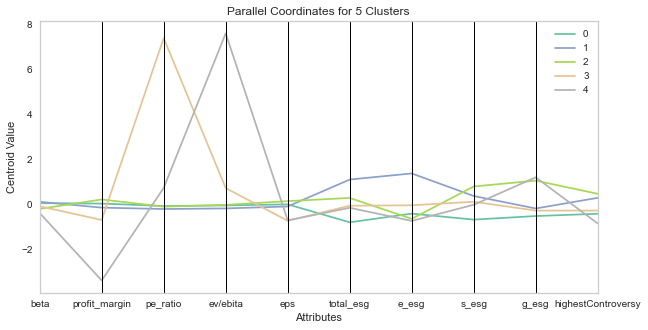

In [ ]:
#Parallel Coordinate Chart for 5 clusters
plt.figure(figsize=(10, 5))
plt.title('Parallel Coordinates for 5 Clusters')
plt.xlabel('Attributes')
plt.ylabel('Centroid Value')
pd.plotting.parallel_coordinates(df_5centroids,'Cluster', colormap=plt.get_cmap("Set2"));


In [ ]:
details_5clusters = [(name,cluster) for name, cluster in zip(df_all.index,label)]
for detail in details_5clusters:
    print(detail)

('MMM', 1)
('AOS', 0)
('ABT', 2)
('ABBV', 2)
('ACN', 0)
('ATVI', 2)
('ADM', 1)
('ADBE', 0)
('ADP', 0)
('AAP', 0)
('AES', 1)
('AFL', 2)
('A', 0)
('APD', 0)
('AKAM', 0)
('ALB', 1)
('ARE', 0)
('ALLE', 0)
('LNT', 0)
('ALL', 2)
('GOOGL', 2)
('MO', 2)
('AMZN', 2)
('AEE', 1)
('AAL', 1)
('AEP', 1)
('AXP', 2)
('AIG', 2)
('AMT', 0)
('AWK', 1)
('AMP', 2)
('ABC', 0)
('AME', 0)
('AMGN', 2)
('APH', 0)
('ADI', 0)
('ANSS', 0)
('APA', 1)
('AAPL', 2)
('AMAT', 0)
('APTV', 0)
('ACGL', 2)
('ANET', 0)
('AJG', 2)
('AIZ', 2)
('T', 2)
('ATO', 1)
('ADSK', 0)
('AZO', 0)
('AVB', 0)
('AVY', 0)
('BALL', 0)
('BAC', 2)
('BBWI', 0)
('BAX', 2)
('BDX', 2)
('WRB', 2)
('BBY', 0)
('BIO', 4)
('BIIB', 2)
('BLK', 2)
('BK', 2)
('BA', 1)
('BKNG', 2)
('BWA', 0)
('BXP', 0)
('BSX', 2)
('BMY', 2)
('AVGO', 0)
('BR', 0)
('BRO', 2)
('CHRW', 0)
('CDNS', 0)
('CPT', 0)
('CPB', 1)
('COF', 2)
('CAH', 0)
('KMX', 0)
('CCL', 1)
('CAT', 2)
('CBOE', 0)
('CBRE', 0)
('CDW', 0)
('CE', 1)
('CNC', 2)
('CNP', 1)
('CF', 1)
('SCHW', 2)
('CHTR', 2)
('CV

In [ ]:
df_all['Cluster'] = label
df_all

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460000,33.61,12.33,13.56,7.72,3,1
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.140000,24.20,7.12,10.84,6.24,0,0
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,2
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,2
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.150000,9.71,0.29,4.58,4.83,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319.HK,Mengniu Dairy,Commerce & Industry,Hong Kong,0.654901,0.06481,22.365269,27.425,1.670000,34.00,14.56,12.71,6.72,0,1
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.787870,15.457,0.660000,27.75,8.56,10.53,8.66,2,3
9888.HK,Baidu,Commerce & Industry,Hong Kong,0.627485,0.03494,32.250166,-1.005,7.837194,20.72,2.99,9.29,8.44,3,2


In [ ]:
for i in u_labels:
    print('Cluster',i,':',(df_all['Cluster']==i).sum())

Cluster 0 : 223
Cluster 1 : 128
Cluster 2 : 128
Cluster 3 : 7
Cluster 4 : 4


In [ ]:
fiveCluster_0 = df_all.loc[df_all['Cluster']==0]
fiveCluster_0.to_csv('fiveCluster_0.csv')
fiveCluster_0

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
AOS,A. O. Smith,Industrials,USA,1.217300,0.12991,19.566877,12.539,3.14,24.20,7.12,10.84,6.24,0,0
ACN,Accenture,Information Technology,USA,1.211925,0.11304,24.144394,15.857,11.15,9.71,0.29,4.58,4.83,2,0
ADBE,Adobe Inc.,Information Technology,USA,1.257183,0.27014,33.010914,22.623,10.08,12.46,1.89,5.93,4.64,1,0
ADP,ADP,Information Technology,USA,0.864318,0.17933,33.263160,22.044,7.22,13.97,1.07,6.96,5.94,1,0
AAP,Advance Auto Parts,Consumer Discretionary,USA,1.138821,0.04304,19.746155,12.736,7.80,12.97,0.10,9.17,3.70,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0669.HK,Techtronic Industries,Commerce & Industry,Hong Kong,1.425098,0.08332,18.061224,111.737,4.90,22.87,8.91,8.06,5.89,1,0
0992.HK,Lenovo,Commerce & Industry,Hong Kong,1.208627,0.02976,4.945737,18.538,1.29,15.25,0.17,7.49,7.59,2,0
2020.HK,Anta Sports,Commerce & Industry,Hong Kong,0.852549,0.14230,34.169384,24.267,3.07,17.42,1.62,8.47,7.34,2,0


In [ ]:
df_all.loc[df_all['Cluster']==0].index.to_list()

['AOS',
 'ACN',
 'ADBE',
 'ADP',
 'AAP',
 'A',
 'APD',
 'AKAM',
 'ARE',
 'ALLE',
 'LNT',
 'AMT',
 'ABC',
 'AME',
 'APH',
 'ADI',
 'ANSS',
 'AMAT',
 'APTV',
 'ANET',
 'ADSK',
 'AZO',
 'AVB',
 'AVY',
 'BALL',
 'BBWI',
 'BBY',
 'BWA',
 'BXP',
 'AVGO',
 'BR',
 'CHRW',
 'CDNS',
 'CPT',
 'CAH',
 'KMX',
 'CBOE',
 'CBRE',
 'CDW',
 'CHD',
 'CI',
 'CTAS',
 'CSCO',
 'CLX',
 'CME',
 'CMS',
 'CTSH',
 'COO',
 'CPRT',
 'GLW',
 'CCI',
 'CSX',
 'CMI',
 'DHI',
 'DHR',
 'DE',
 'XRAY',
 'DLR',
 'DIS',
 'DG',
 'DLTR',
 'DXC',
 'ETN',
 'EBAY',
 'EW',
 'EA',
 'ELV',
 'EQIX',
 'EQR',
 'ESS',
 'RE',
 'ES',
 'EXPD',
 'EXR',
 'FFIV',
 'FDS',
 'FRT',
 'FDX',
 'FIS',
 'FISV',
 'FLT',
 'FTNT',
 'BEN',
 'GRMN',
 'GIS',
 'GPC',
 'HIG',
 'HAS',
 'PEAK',
 'HSIC',
 'HPE',
 'HLT',
 'HD',
 'HST',
 'HPQ',
 'IBM',
 'IDXX',
 'ITW',
 'ILMN',
 'INTC',
 'ICE',
 'IPG',
 'IFF',
 'INTU',
 'IQV',
 'IRM',
 'JBHT',
 'JKHY',
 'JCI',
 'JNPR',
 'KEYS',
 'KMB',
 'KIM',
 'KMI',
 'KLAC',
 'KR',
 'LRCX',
 'LDOS',
 'LNC',
 'LKQ',
 'LOW',
 'M

In [ ]:
#Display Cluster 1
fiveCluster_1 = df_all.loc[df_all['Cluster']==1]
fiveCluster_1.to_csv('fiveCluster_1.csv')
fiveCluster_1

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
MMM,3M,Industrials,USA,0.986396,0.18914,11.057591,11.635,11.460,33.61,12.33,13.56,7.72,3,1
ADM,ADM,Consumer Staples,USA,0.844109,0.04157,12.278571,10.672,7.000,36.40,18.23,13.16,5.01,3,1
AES,AES Corporation,Utilities,USA,0.972701,-0.02231,32.250166,11.946,-0.223,34.15,16.48,11.20,6.47,2,1
ALB,Albemarle Corporation,Materials,USA,1.520404,0.27775,16.803640,13.170,13.190,28.80,15.53,5.54,7.73,2,1
AEE,Ameren,Utilities,USA,0.446110,0.14459,22.135338,13.153,3.990,29.44,14.11,9.84,5.49,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0857.HK,PetroChina Company Limited,Commerce & Industry,Hong Kong,0.797254,0.04305,4.223529,2.319,0.850,55.01,22.66,19.41,12.94,5,1
0883.HK,CNOOC Limited,Commerce & Industry,Hong Kong,0.928235,0.32929,3.703704,1.485,2.700,43.29,22.15,10.59,10.55,2,1
1044.HK,Hengan International Group Co. Ltd,Commerce & Industry,Hong Kong,0.484313,0.12216,15.914398,11.787,2.570,29.90,10.58,9.49,9.83,0,1


In [ ]:
df_all.loc[df_all['Cluster']==1].index.to_list()

['MMM',
 'ADM',
 'AES',
 'ALB',
 'AEE',
 'AAL',
 'AEP',
 'AWK',
 'APA',
 'ATO',
 'BA',
 'CPB',
 'CCL',
 'CE',
 'CNP',
 'CF',
 'CVX',
 'KO',
 'CAG',
 'COP',
 'ED',
 'COST',
 'CTRA',
 'DRI',
 'DVN',
 'D',
 'DPZ',
 'DOV',
 'DTE',
 'DUK',
 'DD',
 'EMN',
 'ECL',
 'EIX',
 'EMR',
 'ETR',
 'EOG',
 'EQT',
 'EXC',
 'XOM',
 'FAST',
 'FE',
 'FMC',
 'F',
 'FTV',
 'FCX',
 'GD',
 'GE',
 'GM',
 'HAL',
 'HSY',
 'HES',
 'HON',
 'HRL',
 'IEX',
 'IP',
 'K',
 'KHC',
 'LEN',
 'LYB',
 'MRO',
 'MPC',
 'MAR',
 'MLM',
 'MAS',
 'MKC',
 'MCHP',
 'MDLZ',
 'MNST',
 'MOS',
 'NEE',
 'NI',
 'NDSN',
 'NSC',
 'NOC',
 'NCLH',
 'NRG',
 'NUE',
 'OXY',
 'ON',
 'OKE',
 'PCAR',
 'PH',
 'PNR',
 'PCG',
 'PSX',
 'PNW',
 'PXD',
 'PPL',
 'PG',
 'PEG',
 'QRVO',
 'RSG',
 'RCL',
 'SRE',
 'SHW',
 'SWKS',
 'SJM',
 'SNA',
 'SO',
 'LUV',
 'SBUX',
 'STLD',
 'TRGP',
 'TXT',
 'TDG',
 'TSN',
 'UNP',
 'UAL',
 'VLO',
 'VMC',
 'WEC',
 'WMB',
 'XEL',
 '0002.HK',
 '1038.HK',
 '2688.HK',
 '0001.HK',
 '0267.HK',
 '0288.HK',
 '0291.HK',
 '0386.HK',


In [ ]:
#Display Cluster 2
fiveCluster_2 = df_all.loc[df_all['Cluster']==2]
fiveCluster_2.to_csv('fiveCluster_2.csv')
fiveCluster_2

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
ABT,Abbott,Health Care,USA,0.667596,0.17519,25.356660,14.616,4.430000,24.98,3.03,13.59,8.36,3,2
ABBV,AbbVie,Health Care,USA,0.623997,0.23188,22.206667,11.653,7.500000,27.84,1.12,16.77,9.95,3,2
ATVI,Activision Blizzard,Communication Services,USA,0.427624,0.22754,36.427227,24.337,2.130000,18.94,0.15,12.48,6.31,4,2
AFL,Aflac,Financials,USA,0.935704,0.24154,9.491002,8.773,7.780000,17.30,0.47,7.26,9.57,2,2
ALL,Allstate,Financials,USA,0.636205,-0.00413,44.040497,32.825,3.210000,19.22,1.44,7.85,9.94,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093.HK,CSPC Pharmaceutical Group Ltd,Commerce & Industry,Hong Kong,0.752549,0.18677,16.769232,12.174,0.520000,34.01,3.36,18.43,12.22,0,2
1177.HK,Sino Biopharm,Commerce & Industry,Hong Kong,0.537647,0.29057,10.545454,17.544,0.440000,39.45,4.60,20.52,14.33,0,2
1211.HK,BYD Company,Commerce & Industry,Hong Kong,0.542745,0.02927,52.299740,22.239,3.870000,24.05,6.33,7.28,10.44,2,2


In [ ]:
df_all.loc[df_all['Cluster']==2].index.to_list()

['ABT',
 'ABBV',
 'ATVI',
 'AFL',
 'ALL',
 'GOOGL',
 'MO',
 'AMZN',
 'AXP',
 'AIG',
 'AMP',
 'AMGN',
 'AAPL',
 'ACGL',
 'AJG',
 'AIZ',
 'T',
 'BAC',
 'BAX',
 'BDX',
 'WRB',
 'BIIB',
 'BLK',
 'BK',
 'BKNG',
 'BSX',
 'BMY',
 'BRO',
 'COF',
 'CAT',
 'CNC',
 'SCHW',
 'CHTR',
 'CMG',
 'CB',
 'C',
 'CFG',
 'CL',
 'CMCSA',
 'CMA',
 'CSGP',
 'CVS',
 'DVA',
 'DFS',
 'DISH',
 'LLY',
 'EFX',
 'EL',
 'EXPE',
 'FITB',
 'FRC',
 'IT',
 'GILD',
 'GL',
 'GS',
 'HCA',
 'HOLX',
 'HUM',
 'HBAN',
 'INCY',
 'ISRG',
 'IVZ',
 'J',
 'JNJ',
 'JPM',
 'KEY',
 'LH',
 'LVS',
 'LMT',
 'L',
 'LUMN',
 'MTB',
 'MMC',
 'MA',
 'MCD',
 'MDT',
 'MRK',
 'META',
 'MGM',
 'MS',
 'NTRS',
 'PFE',
 'PM',
 'PNC',
 'PGR',
 'PWR',
 'DGX',
 'RJF',
 'REGN',
 'RMD',
 'SBNY',
 'SWK',
 'STT',
 'SYK',
 'SIVB',
 'TMUS',
 'TFX',
 'TSLA',
 'TRV',
 'USB',
 'UNH',
 'UHS',
 'VRSK',
 'VRTX',
 'V',
 'WMT',
 'WFC',
 'WTW',
 'WYNN',
 'ZBH',
 '0005.HK',
 '0011.HK',
 '0388.HK',
 '0939.HK',
 '1398.HK',
 '2388.HK',
 '2628.HK',
 '3968.HK',
 '3988.HK',


In [ ]:
#Display Cluster 3
fiveCluster_3 = df_all.loc[df_all['Cluster']==3]
fiveCluster_3.to_csv('fiveCluster_3.csv')
fiveCluster_3

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
STZ,Constellation Brands,Consumer Staples,USA,0.984554,0.01107,522.51220,15.192,0.41,25.79,10.35,10.04,5.40,2,3
DAL,Delta Air Lines,Industrials,USA,1.221485,0.00174,277.15384,10.178,0.13,26.13,9.52,11.46,5.15,2,3
DXCM,Dexcom,Health Care,USA,1.159051,0.06513,251.78261,105.478,0.46,23.72,5.39,10.24,8.09,0,3
GPN,Global Payments,Information Technology,USA,0.972445,0.00792,438.20834,10.966,0.24,19.18,1.31,10.92,6.95,2,3
CRM,Salesforce,Information Technology,USA,1.129403,0.00918,562.04000,53.822,0.25,13.18,2.34,6.39,4.46,2,3
NOW,ServiceNow,Information Technology,USA,0.959888,0.02905,389.92554,106.952,0.94,15.73,1.41,8.39,5.94,1,3
9618.HK,JD.com,Commerce & Industry,Hong Kong,0.431112,0.00213,378.78787,15.457,0.66,27.75,8.56,10.53,8.66,2,3


In [ ]:
df_all.loc[df_all['Cluster']==3].index.to_list()

['STZ', 'DAL', 'DXCM', 'GPN', 'CRM', 'NOW', '9618.HK']

In [ ]:
#Display Cluster 4
fiveCluster_4 = df_all.loc[df_all['Cluster']==4]
fiveCluster_4.to_csv('fiveCluster_4.csv')
fiveCluster_4

,Company,Sector,Country,beta,profit_margin,pe_ratio,ev/ebita,eps,total_esg,e_esg,s_esg,g_esg,highestControversy,Cluster
Ticker,,,,,,,,,,,,,,
BIO,Bio-Rad,Health Care,USA,0.928520,-2.15161,32.250166,18.711,-3.387,16.87,1.44,8.25,7.19,1,4
CINF,Cincinnati Financial,Financials,USA,0.643529,-0.00429,34.186916,662.834,3.210,25.62,1.82,10.97,12.83,1,4
1299.HK,AIA Group Limited,Financials,Hong Kong,0.920000,0.14304,38.854626,292.200,2.270,13.16,0.56,6.32,6.28,2,4
0027.HK,Galaxy Entertainment Group Ltd.,Commerce & Industry,Hong Kong,0.919215,-0.03015,164.677410,266.863,0.310,28.10,3.38,11.22,13.50,0,4


In [ ]:
df_all.loc[df_all['Cluster']==4].index.to_list()

['BIO', 'CINF', '1299.HK', '0027.HK']

# Trial

C:\Users\Jane Wong\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



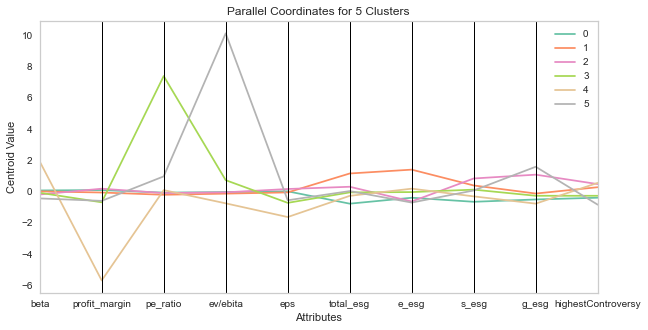

In [ ]:
k_means = KMeans(n_clusters=5, random_state=0)  #change n_clusters only
k_means.fit(df_tr)
label = k_means.labels_
centroids = k_means.cluster_centers_

#Getting unique labels
u_labels = np.unique(label)

df_5centroids=pd.DataFrame(centroids,columns=['beta', 'profit_margin', 'pe_ratio', 'ev/ebita', 'eps', 'total_esg', 'e_esg','s_esg', 'g_esg', 'highestControversy'])
df_5centroids['Cluster']=df_5centroids.index

plt.figure(figsize=(10, 5))
plt.title('Parallel Coordinates for 5 Clusters')
plt.xlabel('Attributes')
plt.ylabel('Centroid Value')
pd.plotting.parallel_coordinates(df_5centroids,'Cluster', colormap=plt.get_cmap("Set2"));

In [ ]:
#robust checking lol: